## Data prep

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import pickle
from sklearn.metrics import r2_score, classification_report

pd.set_option('mode.chained_assignment',None)

In [2]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=10, verbose=False, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 10
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            if self.counter % 5 == 0:
                self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


def r2_loss(output, target):
    target_mean = torch.mean(target)
    ss_tot = torch.sum((target - target_mean) ** 2)
    ss_res = torch.sum((target - output) ** 2)
    r2 = 1 - ss_res / ss_tot
    return -r2

In [3]:
# Load full Data
df_full = pd.read_csv('data/processed/SimpleNNData.csv', index_col=0, parse_dates = [1])
y = df_full.time_to_reservation
df_full.drop(columns=['time_to_reservation', 'hour_index'], inplace=True)

# Load weather
Weather_Scale = pd.read_csv('data/processed/MinMaxWeather.csv', index_col=0)
weather_var = list(Weather_Scale.index)

# Load slicing
with open("data/processed/Sample_CC", "rb") as fp: 
    cc = pickle.load(fp)

df_full.head()

,time,leave_fuel,weekend,Time_Cos,Time_Sin,mean_temp,mean_wind_speed,acc_precip,bright_sunshine,mean_pressure,...,lz_185122,lz_185123,lz_185124,lz_185131,lz_185132,lz_185141,lz_185142,lz_185143,lz_185154,lz_185203
0,2019-10-31 00:00:11,86,0,1.000000,0.000800,6.0,3.4,0.0,0.0,1027.7,...,0,0,0,0,0,0,0,0,0,0
1,2019-10-31 00:01:04,84,0,0.999989,0.004654,6.0,3.4,0.0,0.0,1027.7,...,0,0,0,0,0,0,0,0,0,0
2,2019-10-31 00:01:14,99,0,0.999986,0.005381,6.0,3.4,0.0,0.0,1027.7,...,0,0,0,0,0,0,0,0,0,0
3,2019-10-31 00:02:06,52,0,0.999958,0.009163,6.0,3.4,0.0,0.0,1027.7,...,0,0,0,0,0,0,0,0,0,0
4,2019-10-31 00:03:33,47,0,0.999880,0.015489,6.0,3.4,0.0,0.0,1027.7,...,0,0,0,0,0,0,0,0,1,0


In [4]:
# For classification
Clas_Coef = dict(pd.concat([df_full.time.dt.hour.iloc[cc[0]],y[cc[0]]], axis = 1).groupby('time')['time_to_reservation'].mean()*2)
df_clas = pd.concat([df_full.time.dt.hour.iloc[cc[2]],y[cc[2]]], axis = 1)
df_clas['Cut'] = df_clas.time.map(dict(Clas_Coef))

In [5]:
# Common setting
batch_size = 512
num_epochs = 501

## No Zones

In [6]:
df = df_full.drop(columns = list(df_full.filter(regex = 'lz').columns) + weather_var + ['dist_to_station','time'])
df['leave_fuel'] = df['leave_fuel']/100
df['degree'] = df['degree']/50
df.head()

,leave_fuel,weekend,Time_Cos,Time_Sin,degree,eng_118I,eng_COOPER,eng_I3,eng_X1
0,0.86,0,1.000000,0.000800,0.360118,0,1,0,0
1,0.84,0,0.999989,0.004654,0.197445,0,0,1,0
2,0.99,0,0.999986,0.005381,0.282942,0,0,0,1
3,0.52,0,0.999958,0.009163,0.046701,0,1,0,0
4,0.47,0,0.999880,0.015489,0.353928,0,1,0,0


In [7]:
X_train = torch.tensor(df.iloc[cc[0]].to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y[cc[0]].to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(df.iloc[cc[1]].to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y[cc[1]].to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(df.iloc[cc[2]].to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y[cc[2]].to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [8]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(9,32),
            nn.ReLU(),
            nn.Dropout(0.0),
            nn.Linear(32,16),
            nn.ReLU(),
            nn.Dropout(0.0),
            #nn.Linear(64,32),
            #nn.ReLU(),
            #nn.Dropout(0.0),
            nn.Linear(16,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x

net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=9, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
) 865


Epoch  1: Train Loss 0.006288 , Valid Loss -0.084219 ,Train R2 0.094303, Valid R2 0.088827
Epoch 11: Train Loss -0.090011 , Valid Loss -0.090772 ,Train R2 0.101352, Valid R2 0.095167
Epoch 21: Train Loss -0.091732 , Valid Loss -0.092258 ,Train R2 0.103138, Valid R2 0.096586
Epoch 31: Train Loss -0.093418 , Valid Loss -0.093725 ,Train R2 0.104908, Valid R2 0.097993
Epoch 41: Train Loss -0.095362 , Valid Loss -0.095742 ,Train R2 0.107180, Valid R2 0.100004
Epoch 51: Train Loss -0.097839 , Valid Loss -0.098413 ,Train R2 0.109814, Valid R2 0.102630
Epoch 61: Train Loss -0.100566 , Valid Loss -0.100694 ,Train R2 0.112123, Valid R2 0.104835
Epoch 71: Train Loss -0.102583 , Valid Loss -0.102617 ,Train R2 0.114082, Valid R2 0.106809
Epoch 81: Train Loss -0.104140 , Valid Loss -0.104045 ,Train R2 0.115603, Valid R2 0.108245
Epoch 91: Train Loss -0.105733 , Valid Loss -0.105287 ,Train R2 0.116976, Valid R2 0.109488
Epoch 101: Train Loss -0.106944 , Valid Loss -0.106278 ,Train R2 0.118094, Valid 

Net(
  (seq): Sequential(
    (0): Linear(in_features=9, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)

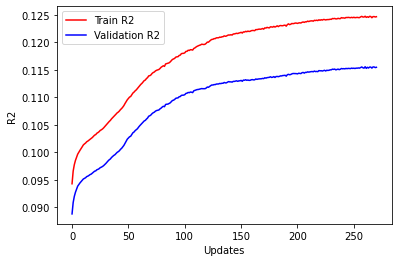

In [9]:
optimizer = optim.Adam(net.parameters(), lr=0.002, weight_decay = 0.0001) #Chaged to Adam and learning + regulariztion rate set

num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

path = 'Results/SimpleNN/NoZones.pt'
early_stopping = EarlyStopping(patience=10, verbose=False, path = path)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = r2_loss(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss_train += batch_loss
    train_losses.append(cur_loss_train/num_batches_train)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())


    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = 0
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val += r2_loss(output, y_val[slce])

    val_losses.append(cur_loss_val/num_batches_valid)

    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train R2','Validation R2'])
plt.xlabel('Updates'), plt.ylabel('R2')

# Load best model
net.load_state_dict(torch.load(path))
net.eval()

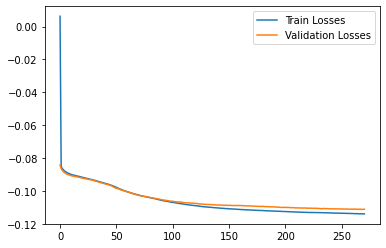

Max Val R2: 0.11556611351005308
Test R2: 0.11976508813479225


In [10]:
plt.plot(epoch, [x.detach().numpy() for x in train_losses], [x.detach().numpy() for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(f'Max Val R2: {max(valid_r2)}')
print(f'Test R2: {r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])}')

In [11]:
df_clas['Preds'] = net.forward(X_test).detach().numpy()[:,0]
print(classification_report(df_clas.time_to_reservation > df_clas.Cut, df_clas.Preds > df_clas.Cut, target_names = ['Under','Over']))

              precision    recall  f1-score   support

       Under       0.86      0.99      0.92     26743
        Over       0.53      0.05      0.09      4402

    accuracy                           0.86     31145
   macro avg       0.70      0.52      0.50     31145
weighted avg       0.82      0.86      0.81     31145



## Add Zones

In [12]:
df = df_full.drop(columns = weather_var + ['dist_to_station','time'])
df['leave_fuel'] = df['leave_fuel']/100
df['degree'] = df['degree']/50
df.head()

,leave_fuel,weekend,Time_Cos,Time_Sin,degree,eng_118I,eng_COOPER,eng_I3,eng_X1,lz_102111,...,lz_185122,lz_185123,lz_185124,lz_185131,lz_185132,lz_185141,lz_185142,lz_185143,lz_185154,lz_185203
0,0.86,0,1.000000,0.000800,0.360118,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.84,0,0.999989,0.004654,0.197445,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.99,0,0.999986,0.005381,0.282942,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0.52,0,0.999958,0.009163,0.046701,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.47,0,0.999880,0.015489,0.353928,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [13]:
X_train = torch.tensor(df.iloc[cc[0]].to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y[cc[0]].to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(df.iloc[cc[1]].to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y[cc[1]].to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(df.iloc[cc[2]].to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y[cc[2]].to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [14]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(265,32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32,16),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(16,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x

net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=265, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
) 9057


Epoch  1: Train Loss 0.411844 , Valid Loss 0.340053 ,Train R2 -0.330980, Valid R2 -0.328887
Epoch 11: Train Loss -0.131137 , Valid Loss -0.147425 ,Train R2 0.157273, Valid R2 0.151714
Epoch 21: Train Loss -0.170489 , Valid Loss -0.183382 ,Train R2 0.195158, Valid R2 0.187343
Epoch 31: Train Loss -0.188863 , Valid Loss -0.198398 ,Train R2 0.212212, Valid R2 0.202377
Epoch 41: Train Loss -0.198792 , Valid Loss -0.206925 ,Train R2 0.222669, Valid R2 0.210915
Epoch 51: Train Loss -0.203140 , Valid Loss -0.211553 ,Train R2 0.228779, Valid R2 0.215558
Epoch 61: Train Loss -0.208338 , Valid Loss -0.214241 ,Train R2 0.232892, Valid R2 0.218278
Epoch 71: Train Loss -0.212086 , Valid Loss -0.216150 ,Train R2 0.235922, Valid R2 0.220175
Epoch 81: Train Loss -0.214783 , Valid Loss -0.217628 ,Train R2 0.238446, Valid R2 0.221693
Epoch 91: Train Loss -0.217675 , Valid Loss -0.218689 ,Train R2 0.240517, Valid R2 0.222731
Epoch 101: Train Loss -0.219824 , Valid Loss -0.219563 ,Train R2 0.242336, Valid

Net(
  (seq): Sequential(
    (0): Linear(in_features=265, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)

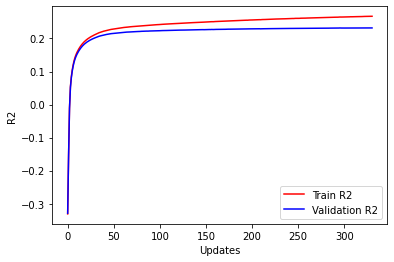

In [15]:
optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay = 0.0001) #Chaged to Adam and learning + regulariztion rate set

num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

path = 'Results/SimpleNN/WithZones.pt'
early_stopping = EarlyStopping(patience=10, verbose=False, path = path)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = r2_loss(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss_train += batch_loss
    train_losses.append(cur_loss_train/num_batches_train)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())


    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = 0
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val += r2_loss(output, y_val[slce])

    val_losses.append(cur_loss_val/num_batches_valid)

    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train R2','Validation R2'])
plt.xlabel('Updates'), plt.ylabel('R2')

# Load best model
net.load_state_dict(torch.load(path))
net.eval()

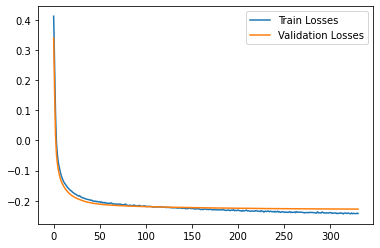

Max Val R2: 0.23204341433402842
Test R2: 0.239084354292885


In [16]:
plt.plot(epoch, [x.detach().numpy() for x in train_losses], [x.detach().numpy() for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(f'Max Val R2: {max(valid_r2)}')
print(f'Test R2: {r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])}')

In [17]:
df_clas['Preds'] = net.forward(X_test).detach().numpy()[:,0]
print(classification_report(df_clas.time_to_reservation > df_clas.Cut, df_clas.Preds > df_clas.Cut, target_names = ['Under','Over']))

              precision    recall  f1-score   support

       Under       0.87      0.97      0.92     26743
        Over       0.44      0.16      0.23      4402

    accuracy                           0.85     31145
   macro avg       0.66      0.56      0.58     31145
weighted avg       0.81      0.85      0.82     31145



## Add Weather + Dist to station

In [18]:
df = df_full.drop(columns = list(df_full.filter(regex = 'lz').columns) + ['time'])
df['leave_fuel'] = df['leave_fuel']/100
df['degree'] = df['degree']/50
df['dist_to_station'] = df['dist_to_station']/5000
df[Weather_Scale.index] = (df[Weather_Scale.index] - Weather_Scale['Min'])/Weather_Scale['diff']
df.head()

,leave_fuel,weekend,Time_Cos,Time_Sin,mean_temp,mean_wind_speed,acc_precip,bright_sunshine,mean_pressure,mean_relative_hum,mean_cloud_cover,dist_to_station,degree,eng_118I,eng_COOPER,eng_I3,eng_X1
0,0.86,0,1.000000,0.000800,0.196347,0.311927,0.0,0.0,0.829885,0.526957,0.85,0.062560,0.360118,0,1,0,0
1,0.84,0,0.999989,0.004654,0.196347,0.311927,0.0,0.0,0.829885,0.526957,0.85,0.115475,0.197445,0,0,1,0
2,0.99,0,0.999986,0.005381,0.196347,0.311927,0.0,0.0,0.829885,0.526957,0.85,0.078189,0.282942,0,0,0,1
3,0.52,0,0.999958,0.009163,0.196347,0.311927,0.0,0.0,0.829885,0.526957,0.85,0.084367,0.046701,0,1,0,0
4,0.47,0,0.999880,0.015489,0.196347,0.311927,0.0,0.0,0.829885,0.526957,0.85,0.192328,0.353928,0,1,0,0


In [19]:
X_train = torch.tensor(df.iloc[cc[0]].to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y[cc[0]].to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(df.iloc[cc[1]].to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y[cc[1]].to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(df.iloc[cc[2]].to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y[cc[2]].to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [20]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(17,128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x

net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=17, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
) 10625


Epoch  1: Train Loss 0.103799 , Valid Loss -0.066792 ,Train R2 0.074402, Valid R2 0.072481
Epoch 11: Train Loss -0.110680 , Valid Loss -0.111237 ,Train R2 0.123917, Valid R2 0.116104
Epoch 21: Train Loss -0.114073 , Valid Loss -0.113413 ,Train R2 0.127216, Valid R2 0.118308
Epoch 31: Train Loss -0.116848 , Valid Loss -0.114592 ,Train R2 0.129040, Valid R2 0.119441
Epoch 41: Train Loss -0.117576 , Valid Loss -0.115498 ,Train R2 0.130414, Valid R2 0.120312
Epoch 51: Train Loss -0.119043 , Valid Loss -0.116402 ,Train R2 0.131738, Valid R2 0.121184
Epoch 61: Train Loss -0.120912 , Valid Loss -0.116891 ,Train R2 0.132630, Valid R2 0.121585
Epoch 71: Train Loss -0.122183 , Valid Loss -0.118410 ,Train R2 0.134425, Valid R2 0.123174
Epoch 81: Train Loss -0.123951 , Valid Loss -0.119311 ,Train R2 0.135733, Valid R2 0.124017
Epoch 91: Train Loss -0.125197 , Valid Loss -0.120123 ,Train R2 0.136939, Valid R2 0.124795
Epoch 101: Train Loss -0.126099 , Valid Loss -0.121148 ,Train R2 0.138500, Valid 

Net(
  (seq): Sequential(
    (0): Linear(in_features=17, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

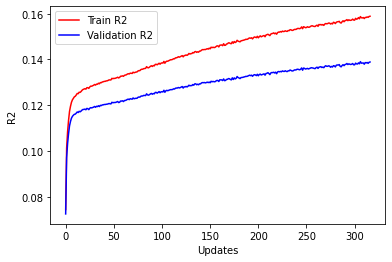

In [21]:
optimizer = optim.Adam(net.parameters(), lr=0.0003, weight_decay = 0.0001) #Chaged to Adam and learning + regulariztion rate set

num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

path = 'Results/SimpleNN/WithWeather.pt'
early_stopping = EarlyStopping(patience=10, verbose=False, path = path)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = r2_loss(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss_train += batch_loss
    train_losses.append(cur_loss_train/num_batches_train)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())


    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = 0
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val += r2_loss(output, y_val[slce])

    val_losses.append(cur_loss_val/num_batches_valid)

    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train R2','Validation R2'])
plt.xlabel('Updates'), plt.ylabel('R2')

# Load best model
net.load_state_dict(torch.load(path))
net.eval()

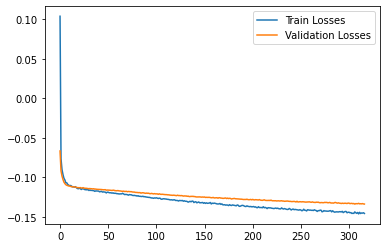

Max Val R2: 0.13903913459857953
Test R2: 0.14583627958019707


In [22]:
plt.plot(epoch, [x.detach().numpy() for x in train_losses], [x.detach().numpy() for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(f'Max Val R2: {max(valid_r2)}')
print(f'Test R2: {r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])}')

In [23]:
df_clas['Preds'] = net.forward(X_test).detach().numpy()[:,0]
print(classification_report(df_clas.time_to_reservation > df_clas.Cut, df_clas.Preds > df_clas.Cut, target_names = ['Under','Over']))

              precision    recall  f1-score   support

       Under       0.86      0.99      0.92     26743
        Over       0.48      0.04      0.08      4402

    accuracy                           0.86     31145
   macro avg       0.67      0.52      0.50     31145
weighted avg       0.81      0.86      0.80     31145



## With all

In [24]:
df = df_full.drop(columns = ['time'])
df['leave_fuel'] = df['leave_fuel']/100
df['degree'] = df['degree']/50
df['dist_to_station'] = df['dist_to_station']/5000
df[Weather_Scale.index] = (df[Weather_Scale.index] - Weather_Scale['Min'])/Weather_Scale['diff']
df.head()

,leave_fuel,weekend,Time_Cos,Time_Sin,mean_temp,mean_wind_speed,acc_precip,bright_sunshine,mean_pressure,mean_relative_hum,...,lz_185122,lz_185123,lz_185124,lz_185131,lz_185132,lz_185141,lz_185142,lz_185143,lz_185154,lz_185203
0,0.86,0,1.000000,0.000800,0.196347,0.311927,0.0,0.0,0.829885,0.526957,...,0,0,0,0,0,0,0,0,0,0
1,0.84,0,0.999989,0.004654,0.196347,0.311927,0.0,0.0,0.829885,0.526957,...,0,0,0,0,0,0,0,0,0,0
2,0.99,0,0.999986,0.005381,0.196347,0.311927,0.0,0.0,0.829885,0.526957,...,0,0,0,0,0,0,0,0,0,0
3,0.52,0,0.999958,0.009163,0.196347,0.311927,0.0,0.0,0.829885,0.526957,...,0,0,0,0,0,0,0,0,0,0
4,0.47,0,0.999880,0.015489,0.196347,0.311927,0.0,0.0,0.829885,0.526957,...,0,0,0,0,0,0,0,0,1,0


In [25]:
X_train = torch.tensor(df.iloc[cc[0]].to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y[cc[0]].to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(df.iloc[cc[1]].to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y[cc[1]].to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(df.iloc[cc[2]].to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y[cc[2]].to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [26]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(273,32),
            nn.ReLU(),
            nn.Dropout(0.15),
            nn.Linear(32,16),
            nn.ReLU(),
            nn.Dropout(0.15),
            nn.Linear(16,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x

net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=273, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.15, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.15, inplace=False)
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
) 9313


Epoch  1: Train Loss 0.450951 , Valid Loss 0.355981 ,Train R2 -0.346941, Valid R2 -0.344600
Epoch 11: Train Loss -0.128061 , Valid Loss -0.148798 ,Train R2 0.158242, Valid R2 0.152832
Epoch 21: Train Loss -0.167933 , Valid Loss -0.183665 ,Train R2 0.196010, Valid R2 0.187666
Epoch 31: Train Loss -0.182867 , Valid Loss -0.198228 ,Train R2 0.213075, Valid R2 0.202246
Epoch 41: Train Loss -0.195641 , Valid Loss -0.206417 ,Train R2 0.223394, Valid R2 0.210481
Epoch 51: Train Loss -0.201584 , Valid Loss -0.211095 ,Train R2 0.229630, Valid R2 0.215160
Epoch 61: Train Loss -0.205839 , Valid Loss -0.213873 ,Train R2 0.233757, Valid R2 0.217928
Epoch 71: Train Loss -0.207214 , Valid Loss -0.215896 ,Train R2 0.236957, Valid R2 0.219954
Epoch 81: Train Loss -0.211386 , Valid Loss -0.217124 ,Train R2 0.239409, Valid R2 0.221141
Epoch 91: Train Loss -0.215075 , Valid Loss -0.218449 ,Train R2 0.241929, Valid R2 0.222497
Epoch 101: Train Loss -0.216424 , Valid Loss -0.219576 ,Train R2 0.244269, Valid

Net(
  (seq): Sequential(
    (0): Linear(in_features=273, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.15, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.15, inplace=False)
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)

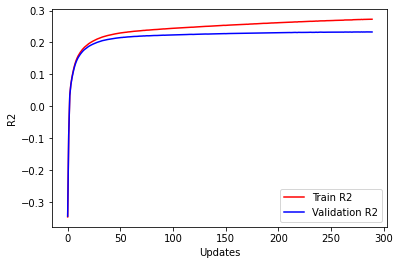

In [27]:
optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay = 0.0001) #Chaged to Adam and learning + regulariztion rate set

num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

path = 'Results/SimpleNN/Full.pt'
early_stopping = EarlyStopping(patience=10, verbose=False, path = path)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = r2_loss(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss_train += batch_loss
    train_losses.append(cur_loss_train/num_batches_train)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())


    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = 0
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val += r2_loss(output, y_val[slce])

    val_losses.append(cur_loss_val/num_batches_valid)

    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train R2','Validation R2'])
plt.xlabel('Updates'), plt.ylabel('R2')

# Load best model
net.load_state_dict(torch.load(path))
net.eval()

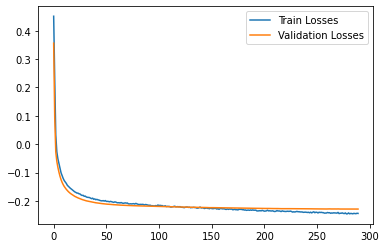

Max Val R2: 0.23295592497417306
Test R2: 0.24108647375236947


In [28]:
plt.plot(epoch, [x.detach().numpy() for x in train_losses], [x.detach().numpy() for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(f'Max Val R2: {max(valid_r2)}')
print(f'Test R2: {r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])}')

In [29]:
df_clas['Preds'] = net.forward(X_test).detach().numpy()[:,0]
print(classification_report(df_clas.time_to_reservation > df_clas.Cut, df_clas.Preds > df_clas.Cut, target_names = ['Under','Over']))

              precision    recall  f1-score   support

       Under       0.88      0.97      0.92     26743
        Over       0.45      0.17      0.25      4402

    accuracy                           0.85     31145
   macro avg       0.66      0.57      0.58     31145
weighted avg       0.82      0.85      0.82     31145

